In [35]:
import re
import pandas as pd

# Gebsim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import warnings

# pyLDAvis
!pip install pyLDAvis
import pyLDAvis.gensim_models

# Coherence
from gensim.models.coherencemodel import CoherenceModel

warnings.filterwarnings("ignore")
from pprint import pprint

In [36]:
data = pd.read_csv('../data/reviews_clean.csv')

In [37]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
extra_words =["hotel", "room", "nt", "great", 'night', 'day', 'stay', 'stayed', 'time', 'location']

"""
'also', 'meanwhile','however', 'time', 'hour', 'soon', 'day', \
'book', 'there', 'hotel', 'room', 'leave', 'arrive', 'place', \
'stay', 'staff', 'location', 'service', 'come', 'check', 'ask', \
'lot', 'thing', 'soooo', 'add', \
'rarely', 'use', 'look', 'minute', 'bring', 'need', 'world',
, 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know',
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even',
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'
"""
stopwords.extend(extra_words)

In [38]:
for x in range(len(data)):
    data['Review_lemmatized'][x] = re.sub(r'[^\w\s]', '',  data['Review_lemmatized'][x])

In [39]:
# N-gram

nltk.download('averaged_perceptron_tagger')
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in  data['Review_lemmatized']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)


# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stopwords or bigram[1] in stopwords:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    return True



# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\larsb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [40]:
# Concatenate n-grams
def replace_ngram(z):
    for gram in bigrams:
        z = z.replace(gram, '_'.join(gram.split()))
    return z


reviews_w_ngrams = data['Review_lemmatized'].copy()
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: replace_ngram(x))
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: [word for word in x.split()\
                                                 if word not in stopwords\
                                                              and len(word) > 2])

reviews_w_ngrams.head()


0    [nice, expensive, parking, got, good, deal, anniversary, arrived, late, evening, took, advice, p...
1    [nothing_special, charge, diamond, member, hilton, decided, chain, shot, th_anniversary, seattle...
2    [nice, experience, monaco, seattle, good, levelpositives, large, bathroom, mediterranean, suite,...
3    [unique, wonderful, monaco, excellent, short, stroll, main, downtown, shopping, area, pet, frien...
4    [went, seahawk, game, awesome, downfall, view, building, complain, huge, staff, helpful, booked,...
Name: Review_lemmatized, dtype: object

In [41]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)


In [42]:
# LDA model
dictionary = corpora.Dictionary(final_reviews)

print('Number of unique words in initital documents:', len(dictionary))
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print('Number of unique words after removing rare and common words:', len(dictionary))

doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=3,
                                           random_state=100,
                                           chunksize=2000,
                                           passes=40,
                                           alpha=.1,
                                           eta= 0.01,
                                           iterations=100,
                                           #per_word_topics=True
                                                )

Number of unique words in initital documents: 48538
Number of unique words after removing rare and common words: 9595


In [43]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]


[(0,
  '0.010*"desk" + 0.010*"got" + 0.009*"service" + 0.009*"told" + '
  '0.008*"problem" + 0.008*"bed" + 0.008*"asked" + 0.008*"said" + '
  '0.008*"check" + 0.007*"booked"'),
 (1,
  '0.024*"breakfast" + 0.014*"area" + 0.013*"place" + 0.013*"view" + '
  '0.013*"restaurant" + 0.012*"bathroom" + 0.012*"city" + 0.011*"service" + '
  '0.011*"street" + 0.009*"price"'),
 (2,
  '0.026*"beach" + 0.025*"resort" + 0.024*"food" + 0.022*"pool" + '
  '0.013*"restaurant" + 0.010*"bar" + 0.010*"service" + 0.009*"place" + '
  '0.009*"went" + 0.009*"water"')]


In [44]:
# Lists documents most dominant topics and its percentage contribution in each document.

def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df.Dominant_Topic = sent_topics_df.Dominant_Topic.astype('Int64')

    # Add original text to the end of the output
    contents = pd.Series(data['Review'])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df



In [75]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.6477,"desk, got, service, told, problem, bed, asked, said, check, booked","nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv..."
1,1,0,0.7703,"desk, got, service, told, problem, bed, asked, said, check, booked","ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta..."
2,2,0,0.8120,"desk, got, service, told, problem, bed, asked, said, check, booked",nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...
3,3,1,0.6142,"breakfast, area, place, view, restaurant, bathroom, city, service, street, price","unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s..."
4,4,0,0.4321,"desk, got, service, told, problem, bed, asked, said, check, booked","great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ..."
5,5,1,0.5066,"breakfast, area, place, view, restaurant, bathroom, city, service, street, price",love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husb...
6,6,1,0.7420,"breakfast, area, place, view, restaurant, bathroom, city, service, street, price","cozy stay rainy city, husband spent 7 nights monaco early january 2008. business trip chance com..."
7,7,0,0.6850,"desk, got, service, told, problem, bed, asked, said, check, booked","excellent staff, housekeeping quality hotel chocked staff make feel home, experienced exceptiona..."
8,8,1,0.6253,"breakfast, area, place, view, restaurant, bathroom, city, service, street, price","hotel stayed hotel monaco cruise, rooms generous decorated uniquely, hotel remodeled pacific bel..."
9,9,1,0.9837,"breakfast, area, place, view, restaurant, bathroom, city, service, street, price","excellent stayed hotel monaco past w/e delight, reception staff friendly professional room smart..."


In [48]:
# Lists all topics and displays the most central tokens and representative sentence for each topic.

pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9982,"desk, got, service, told, problem, bed, asked, said, check, booked","horrible customer service worst hilton possibly worst hotel, trying review guidelines feel impor..."
1,1,0.9964,"breakfast, area, place, view, restaurant, bathroom, city, service, street, price",great longer stay husband recently stayed quay west week having recommended comfort suite ordina...
2,2,0.9993,"beach, resort, food, pool, restaurant, bar, service, place, went, water","ca n't wait till year, 2nd 16th 2008we stayed lofts week 3 adults allow 2 adults suite rs.the se..."


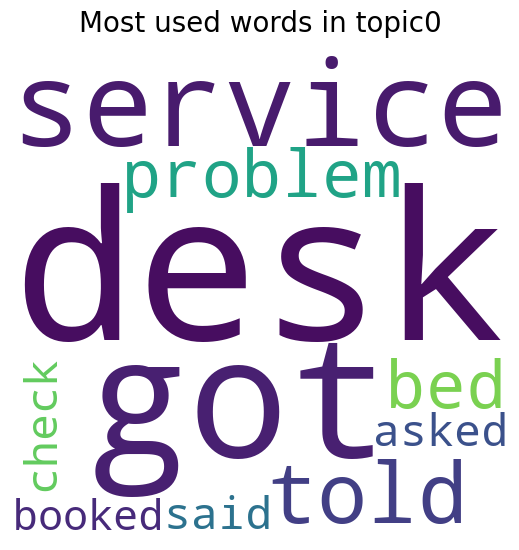

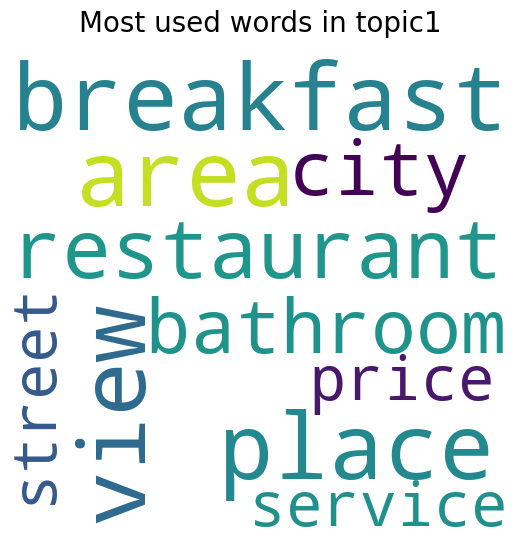

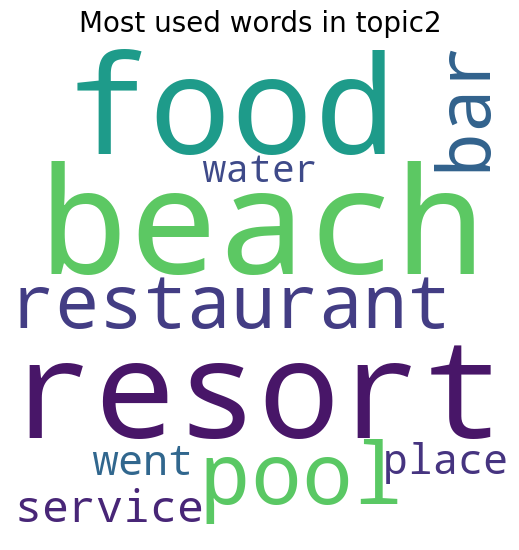

In [50]:
# Wordcloud of top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data))

    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=20)
    plt.show()


topics = lda_model.show_topics(formatted=False)
for x in range(len(topics)):
    create_WordCloud(dict(topics[x][1]), title="Most used words in topic" + str(x))



In [51]:
# U-mass and C_v cohesion..
cm = CoherenceModel(model=lda_model, corpus=doc_term_matrix, coherence='u_mass')
u_mass_score = cm.get_coherence()

#Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_reviews, dictionary=dictionary, coherence='c_v')
c_v_score = coherence_model_lda.get_coherence()

print('U_mass Score: ', u_mass_score,
      '\nC_v Score: ', c_v_score)

U_mass Score:  -1.5547035637209996 
C_v Score:  0.39547298047289764


In [52]:
# pyLDAvis visualization:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.051923 -0.176281       1        1  36.294709
1     -0.142809  0.128816       2        1  34.542713
0      0.194732  0.047465       3        1  29.162578, topic_info=           Term          Freq         Total Category  logprob  loglift
3312      beach   9373.000000   9373.000000  Default  30.0000  30.0000
3282     resort   8873.000000   8873.000000  Default  29.0000  29.0000
721        pool   7898.000000   7898.000000  Default  28.0000  28.0000
309        food  10020.000000  10020.000000  Default  27.0000  27.0000
47    breakfast   9207.000000   9207.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
292        went   1600.749961   5057.246409   Topic3  -5.1855   0.0819
30         took   1312.198937   3028.516445   Topic3  -5.3842   0.3959
456      minute   1227.140013   2988.295308   Topic3  -5.4512   0.3423
199         way   1238.391543   4535.369567   Topic3  -5.4421  -0.0658
270       place   1281.709181   9100.671042   Topic3  -5.4077  -0.7279

[240 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
230       1  0.999762   activity
3542      2  0.999472  amsterdam
1416      2  0.999610  apartment
811       2  1.000008  appointed
204       1  0.260559       area
...     ...       ...        ...
292       2  0.023333       went
292       3  0.316575       went
202       1  0.281932       work
202       2  0.085587       work
202       3  0.632517       work

[343 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [53]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic.
lambd = 1 # Adjust this accordingly based on tuning above in pyLDAvis.
for i in range(1,4): #Adjust this to reflect number of topics chosen for final LDA model.
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,beach,resort,food,pool,restaurant,bar,service,place,went,water
Topic 2,breakfast,area,place,view,restaurant,bathroom,city,service,street,price
Topic 3,desk,got,service,told,problem,bed,asked,said,check,booked


In [54]:
"""
# LDA model
dictionary = corpora.Dictionary(final_reviews)

print('Number of unique words in initital documents:', len(dictionary))
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print('Number of unique words after removing rare and common words:', len(dictionary))

doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


# Test diffen k-values for LDA
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 15, start = 1, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=2000,
                                           passes=40,
                                           alpha='symmetric',
                                           eta= 0.1,
                                           iterations=100,
                                           #per_word_topics=True
                                                )

        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = dictionary, corpus = doc_term_matrix, texts = final_reviews, start = 1, limit = 15, step = 2)



limit, start, step = 15, 1, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

"""

'\n# LDA model\ndictionary = corpora.Dictionary(final_reviews)\n\nprint(\'Number of unique words in initital documents:\', len(dictionary))\n# Filter out words that occur less than 5 documents, or more than 50% of the documents.\ndictionary.filter_extremes(no_below=5, no_above=0.5)\nprint(\'Number of unique words after removing rare and common words:\', len(dictionary))\n\ndoc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]\n\n\n# Test diffen k-values for LDA\nfrom gensim.models.ldamulticore import LdaMulticore\n\ndef calc_coherence_values(dictionary, corpus, texts, limit = 15, start = 1, step = 2):\n    coherence_values = []\n    model_list = []\n    for num_topics in range(start, limit, step):\n\n        model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,\n                                           id2word=dictionary,\n                                           num_topics=num_topics,\n                                           random_state=100,\n         

In [55]:
# Gives us topic topic distribution within corpus.
df_dominant_topic['Dominant_Topic'].value_counts(normalize=True) * 100

1    55.819628
2    23.771412
0     20.40896
Name: Dominant_Topic, dtype: Float64

In [56]:
import plotly.express as px

fig = px.pie(df_dominant_topic, names='Dominant_Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()
